In [327]:
class Bereshit:
    class PID:
        def __init__(self, P=0.05, I=0.00002, D=0.2, SetPoint=30):
            """
            Initialize the PID controller with given gains.
            """
            self.Kp = P  # Proportional gain
            self.Ki = I  # Integral gain
            self.Kd = D  # Derivative gain

            self.set_point = SetPoint  # Desired target value
            self.integral = 0  # Integral term accumulator
            self.error=0
            self.derivative=0
            self.previous_error = 0  # Previous error for derivative calculation
            self.pid = 0  # Output of the PID controller
            self.first_run = True  # Flag to indicate if it's the first run

        def update(self, current_value, dt=1):
            """
            Update the PID controller with the current value and time step.

            :param current_value: The current value to control.
            :param dt: Time step since the last update.
            """
            # Calculate error
            self.error = current_value - self.set_point

            # Integral term
            self.integral += self.error * dt

            # Derivative term
            if self.first_run:
                self.derivative = 0
                self.first_run = False
            else:
                self.derivative = (self.error - self.previous_error) / dt

            # Update previous error for next iteration
            self.previous_error = self.error

            # Calculate output
            self.pid = self.Kp * self.error + self.Ki * self.integral + self.Kd * self.derivative

        def update_set_point(self, set_point):
            """
            Update the set point for the PID controller.

            :param set_point: The desired target value.
            """
            if set_point != self.set_point:
                self.set_point = set_point
                # self.integral = 0  # Reset integral term

    def __init__(
            self,
            wight_emp=165,  # kg (empty weight of the module, perhaps)
            max_fuel_weight=420,  # kg (max fuel tank weight)
            fuel=120.84,  # kg (initial fuel amount)
            main_eng_f=430,  # N (main engine thrust)
            second_eng_f=25,  # N (secondary engine thrust)
            main_burn=0.15,  # liter per sec (main engine fuel burn)
            second_burn=0.009,  # liter per sec (secondary engine fuel burn)
            vs=24.8,  # vertical speed (m/s)
            dvs=30,  # desired vertical speed (m/s)
            dhs=932,  # desired horizontal speed (m/s)
            hs=932,  # horizontal speed (m/s)
            dist=181 * 1000,  # distance (m)
            alt=13722.47,  # altitude (m)
            ang=60,  # angle in degrees (0 is vertical)
            time=0,  # simulation time (sec)
            dt=1,  # time step (sec)
            acc_val=0,  # acceleration rate (m/s²)
            nn=0.7,  # throttle (rate between 0 and 1)
            Kp=0.05, Ki=0.00002, Kd=0.2,         # Throttle PID gains
            angle_Kp=0.1, angle_Ki=0.0001, angle_Kd=0.1,  # NEW: Angle PID gains
            data_log=[]
    ):
        """
        Initialize the Bereshit lander with given parameters.
        """
        self.WEIGHT_EMP = wight_emp
        self.MAX_FUEL_WEIGHT = max_fuel_weight
        self.MAX_WEIGHT = wight_emp + max_fuel_weight,
        self.fuel = fuel
        self.weight = wight_emp + fuel  # current weight (kg)
        self.MAIN_ENG_F = main_eng_f
        self.SECOND_ENG_F = second_eng_f
        self.MAIN_BURN = main_burn
        self.SECOND_BURN = second_burn
        self.ALL_BURN = main_burn + 8 * second_burn  # total burn rate (liters per sec)
        self.vertical_speed = vs
        self.desired_vertical_speed = dvs  # desired vertical speed (m/s)
        self.horizontal_speed = hs
        self.distance = dist
        self.altitude = alt
        self.angle = ang  # angle in degrees (0 is vertical)
        self.desired_horizontal_speed = dhs  # desired angle in degrees (0 is vertical)
        self.time = time  # simulation time (sec)
        self.dt = dt  # time step (sec)
        self.acc_val = acc_val  # acceleration rate (m/s²)
        self.NN = nn  # throttle (rate between 0 and 1)
        self.NN_pid = self.PID(Kp, Ki, Kd, dvs)  # PID controller for throttle adjustment
        self.angle_pid = self.PID(angle_Kp, angle_Ki, angle_Kd, dhs)  # NEW: PID for angle (horizontal speed target 0 m/s)
        self.data_log = data_log  # List to store simulation data

    def acc(self, weight, main, seconds):
        """Calculate acceleration given weight, main engine flag, and amount of running second engines."""
        t = 0
        if main:
            t += self.MAIN_ENG_F
        t += seconds * self.SECOND_ENG_F
        return t / weight

    def acc_max(self, weight):
        """Compute the maximum possible acceleration given weight."""
        return self.acc(weight, True, 8)

    def parabolic_curve(self, height, floor=4000, target=25, base=30, attribute='dvs'):
        """
        ממפה גובה בין 0 ל-4000 לערך בין 0 ל-30 בצורה של קשת מתונה (פרבולה הפוכה)
        """

        if height > floor:
            return base

        # ננרמל את הגובה ל-x בין 0 ל-1
        x = height / floor  # Normalize height to a value between 0 and 1

        # פרבולה בצורת קשת עולה: y = -a*(x - 1)^2 + a
        # תוצאה בין 0 ל-1
        y = -1 * (x - 1) ** 2 + 1

        # המרה לטווח 0 עד הטווח הרצוי
        output = y * target  # Scale to the desired range

        if attribute == 'dvs':
            return round(output) if output > 1.6 else 1.6

        return round(output)  # Round the output to the nearest integer

    def update_dvs(self):
        """
        Update the desired vertical speed for the PID controller.
        """
        # region naive approach
        # if self.altitude < 4000:
        #     self.desired_vertical_speed = 24
        # if self.altitude < 2000:
        #     self.desired_vertical_speed = 16
        # if self.altitude < 500:
        #     self.desired_vertical_speed = 12
        # if self.altitude < 100:
        #     self.desired_vertical_speed = 6
        # if self.altitude < 20:
        #     self.desired_vertical_speed = 3
        # if self.altitude < 10:
        #     self.desired_vertical_speed = 1.6
        # endregion

        self.desired_vertical_speed = self.parabolic_curve(self.altitude, floor=1000, target=23, base=25)  # Update desired vertical

        # speed based on altitude
        if self.altitude > 12000:
            self.desired_vertical_speed += 5.5
        elif self.altitude > 10000:
            self.desired_vertical_speed += 5
        elif self.altitude > 8000:
            self.desired_vertical_speed += 4.8
        elif self.altitude > 6500:
            self.desired_vertical_speed += 4.1
        elif self.altitude > 5000:
            self.desired_vertical_speed += 3.3
        elif self.altitude > 3000:
            self.desired_vertical_speed += 2.7
        elif self.altitude > 2000:
            self.desired_vertical_speed += 2.2
        elif self.altitude > 1000:
            self.desired_vertical_speed += 0.9
        else:
            self.desired_vertical_speed = max(2.2,self.desired_vertical_speed)
        self.NN_pid.update_set_point(self.desired_vertical_speed)


    def update_NN(self):
        """
        Update the NN PID controller with the current vertical speed and time step.
        """
        self.update_dvs()  # Update the desired vertical speed based on altitude
        self.NN_pid.update(self.vertical_speed, self.dt)
        self.NN += self.NN_pid.pid
        self.NN = max(0, min(1, self.NN))

    def update_dhs(self):
        """
        Update the desired horizontal speed for the PID controller.
        """

        self.desired_horizontal_speed = self.parabolic_curve(self.altitude, floor=1000, target=50, base=self.horizontal_speed, attribute='dhs')  # Update desired vertical speed based on altitude
        self.angle_pid.update_set_point(self.desired_horizontal_speed)  # Update the set point for the angle PID controller

    def update_angle(self):
        # region naive approach
        # if self.horizontal_speed < 0.1:
        #     self.angle = 0
        # elif self.horizontal_speed < 20:
        #     self.angle = 5

        # elif self.altitude > 5000:
        #     # High altitude: keep a steep angle
        #     self.angle = min(60, self.angle + 1)  # Slowly tilt more
        # elif self.altitude > 900:
        #     # Getting lower: prepare for vertical
        #     self.angle = max(50, self.angle - 1)
        # elif self.altitude > 400:
        #     # Almost landing: go near vertical
        #     self.angle = max(20, self.angle - 1)
        # endregion

        """
        Update the angle PID controller with the current horizontal speed and time step.
        """

        self.update_dhs()  # Update the desired horizontal speed based on altitude
        self.angle_pid.update(self.horizontal_speed, self.dt)
        self.angle += self.angle_pid.pid
        self.angle = max(0, min(60, self.angle))
        if self.horizontal_speed < 1:
            self.angle = 0
        elif self.horizontal_speed < 10:
            self.angle = 30
        elif self.horizontal_speed < 50:
            self.angle = 40




    def simulate(self):
        # Reset simulation data log
        self.data_log = []  # Initialize storage for simulation logs

        self.NN_pid.update(self.vertical_speed, self.dt)
        first_run = True  # Flag to indicate if it's the first run

        while self.altitude > 0.2:
            if first_run:
                # Log simulation status
                self.data_log.append({
                    'altitude': round(self.altitude, 3),
                    'horizontal speed': round(self.horizontal_speed, 3),
                    'desired horizontal speed': self.desired_horizontal_speed,
                    'angle': round(self.angle, 3),
                    'angle_pid': round(self.angle_pid.pid, 3),
                    'angle_p': round(self.angle_pid.error, 3),
                    'angle_i': round(self.angle_pid.integral, 3),
                    'angle_d': round(self.angle_pid.derivative, 3),
                    'vertical speed': round(self.vertical_speed, 3),
                    'desired vertical speed': self.desired_vertical_speed,
                    'throttle (NN)': round(self.NN, 3),
                    'NN_pid': round(self.NN_pid.pid, 3),
                    'NN_p': round(self.NN_pid.error, 3),
                    'NN_i': round(self.NN_pid.integral, 3),
                    'NN_d': round(self.NN_pid.derivative, 3),
                    'fuel amount': round(self.fuel, 3),
                    'Gacc': round(Moon.gravitational_pull_acc(self.horizontal_speed), 3),
                    'acceleration': round(1.54, 3),
                    'Hass': round(1.34, 3),
                    'Vass': round(0.77, 3),
                    # 'distance': round(self.distance, 3),
                    'total weight': round(self.weight, 3),
                    'time': round(self.time, 3),
                })
                first_run = False  # Set flag to false after the first run
            else:
                # Log simulation status
                self.data_log.append({
                    'altitude': round(self.altitude, 3),
                    'horizontal speed': round(self.horizontal_speed, 3),
                    'desired horizontal speed': round(self.desired_horizontal_speed, 3),
                    # 'angle': self.angle,
                    'angle': round(self.angle, 3),
                    'angle_pid': round(self.angle_pid.pid, 3),
                    'angle_p': round(self.angle_pid.error, 3),
                    'angle_i': round(self.angle_pid.integral, 3),
                    'angle_d': round(self.angle_pid.derivative, 3),
                    'vertical speed': round(self.vertical_speed, 3),
                    'desired vertical speed': self.desired_vertical_speed,
                    'throttle (NN)': round(self.NN, 5),
                    'NN_pid': round(self.NN_pid.pid, 5),
                    'NN_p': round(self.NN_pid.error, 3),
                    'NN_i': round(self.NN_pid.integral, 3),
                    'NN_d': round(self.NN_pid.derivative, 3),
                    'fuel amount': round(self.fuel, 3),
                    'Gacc': round(moon_g_acc, 3),
                    'acceleration': round(self.acc_val, 3),
                    'Hass': round(h_acc, 3),
                    'Vass': round(v_acc, 3),
                    # 'distance': round(self.distance, 3),
                    'total weight': round(self.weight, 3),
                    'time': round(self.time, 3),
                })

            self.time += self.dt
            fuel_burn = self.dt * self.ALL_BURN * self.NN  # fuel consumption this step

            if self.fuel > 0:
                self.fuel -= fuel_burn
                self.weight = self.WEIGHT_EMP + self.fuel
                self.acc_val = self.NN * self.acc_max(self.weight)
            else:
                print("RUN OUT OF FUEL!")
                self.acc_val = 0  # no fuel, no thrust
                break # free fall

            # Compute acceleration components
            self.update_angle()  # Update the angle based on altitude
            ang_rad = math.radians(self.angle)
            h_acc = math.sin(ang_rad) * self.acc_val  # horizontal acceleration component
            v_acc = math.cos(ang_rad) * self.acc_val  # vertical acceleration component

            # Lunar gravity acceleration (reduced by horizontal speed)
            moon_g_acc = Moon.gravitational_pull_acc(self.horizontal_speed)

            # Adjust vertical acceleration by lunar gravity
            v_acc -= moon_g_acc


            if self.horizontal_speed > 0:  # TODO: inspect and remove after improvement
                self.horizontal_speed -= h_acc * self.dt  # update horizontal speed
            self.vertical_speed -= v_acc * self.dt  # update vertical speed
            self.distance -= self.horizontal_speed * self.dt  # update horizontal distance
            self.altitude = max(0, self.altitude - (self.vertical_speed * self.dt))  # update altitude

            self.update_NN()  # Update the throttle using PID controller

        # Log simulation status
        self.data_log.append({
            'altitude': round(self.altitude, 3),
            'horizontal speed': round(self.horizontal_speed, 3),
            'desired horizontal speed': self.desired_horizontal_speed,
            'angle': round(self.angle, 3),
            'angle_pid': round(self.angle_pid.pid, 3),
            'angle_p': round(self.angle_pid.error, 3),
            'angle_i': round(self.angle_pid.integral, 3),
            'angle_d': round(self.angle_pid.derivative, 3),
            'vertical speed': round(self.vertical_speed, 3),
            'desired vertical speed': self.desired_vertical_speed,
            'throttle (NN)': round(self.NN, 3),
            'NN_pid': round(self.NN_pid.pid, 3),
            'NN_p': round(self.NN_pid.error, 3),
            'NN_i': round(self.NN_pid.integral, 3),
            'NN_d': round(self.NN_pid.derivative, 3),
            'fuel amount': round(self.fuel, 3),
            'Gacc': round(moon_g_acc, 3),
            'acceleration': round(self.acc_val, 3),
            'Hass': round(h_acc, 3),
            'Vass': round(v_acc, 3),
            # 'distance': round(self.distance, 3),
            'total weight': round(self.weight, 3),
            'time': round(self.time, 3),
        })

        self.data_log = pd.DataFrame(self.data_log)

In [328]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from Moon import Moon

test_P = 0.05
test_I = 0.0002
test_D = 0.2


In [329]:
bereshit = Bereshit(dt=0.5)
bereshit.simulate()
data_log = bereshit.data_log

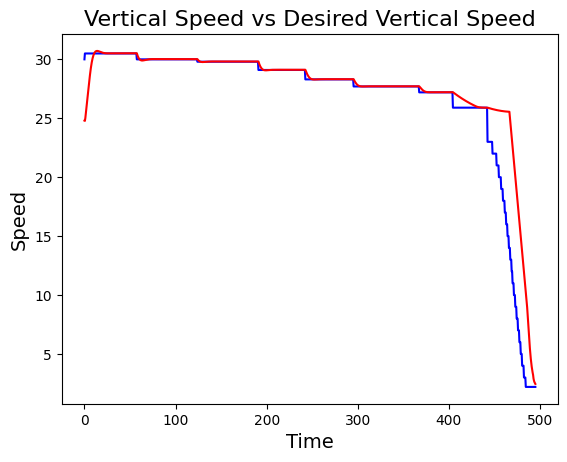

In [330]:
plt.ylabel('Speed', fontsize=14)
plt.xlabel('Time', fontsize=14)

plt.title('Vertical Speed vs Desired Vertical Speed', fontsize=16)

plt.plot(data_log['time'], data_log['desired vertical speed'], label='dvs', color='blue')
plt.plot(data_log['time'], data_log['vertical speed'], label='vs', color='red')

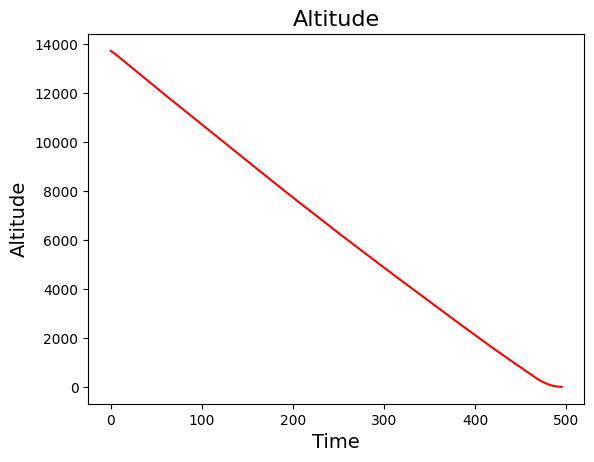

In [331]:
plt.ylabel('Altitude', fontsize=14)
plt.xlabel('Time', fontsize=14)

plt.title('Altitude', fontsize=16)

plt.plot(data_log['time'], data_log['altitude'], label='alt', color='red')

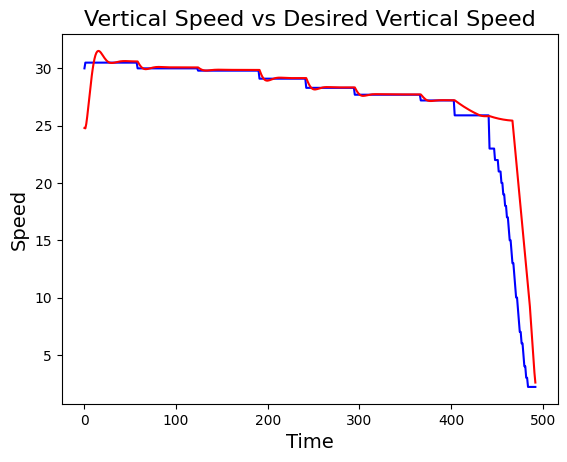

In [332]:
bereshit_2 = Bereshit(Kp=test_P, Ki=test_I, Kd=test_D)
bereshit_2.simulate()
data_log_2 = bereshit_2.data_log

plt.ylabel('Speed', fontsize=14)
plt.xlabel('Time', fontsize=14)

plt.title('Vertical Speed vs Desired Vertical Speed', fontsize=16)

plt.plot(data_log_2['time'], data_log_2['desired vertical speed'], label='dvs', color='blue')
plt.plot(data_log_2['time'], data_log_2['vertical speed'], label='vs', color='red')

In [333]:
data_log

,altitude,horizontal speed,desired horizontal speed,angle,angle_pid,angle_p,angle_i,angle_d,vertical speed,desired vertical speed,...,NN_p,NN_i,NN_d,fuel amount,Gacc,acceleration,Hass,Vass,total weight,time
0,13722.470,932.000,932.000,60,0.000,0.00,0.000,0.000,24.800,30.0,...,-5.200,-2.600,0.000,120.840,0.733,1.540,1.340,0.770,285.840,0.0
1,13710.080,931.332,932.000,60,0.000,0.00,0.000,0.000,24.781,30.5,...,-5.719,-5.460,-1.039,120.762,0.733,1.543,1.336,0.039,285.762,0.5
2,13697.563,931.135,931.332,60,0.000,0.00,0.000,0.000,25.034,30.5,...,-5.466,-8.193,0.506,120.739,0.733,0.455,0.394,-0.506,285.739,1.0
3,13684.872,931.103,931.135,60,0.000,0.00,0.000,0.000,25.382,30.5,...,-5.118,-10.752,0.696,120.736,0.734,0.075,0.065,-0.696,285.736,1.5
4,13671.998,931.103,931.103,60,0.000,0.00,0.000,0.000,25.749,30.5,...,-4.751,-13.128,0.734,120.736,0.734,0.000,0.000,-0.734,285.736,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
986,5.031,0.450,1.000,0,-0.047,-0.55,1241.605,-1.162,2.905,2.2,...,0.705,356.889,-0.639,28.956,1.622,2.260,0.000,0.639,193.956,493.0
987,3.669,0.450,1.000,0,0.069,-0.55,1241.330,0.000,2.724,2.2,...,0.524,357.151,-0.362,28.888,1.622,1.984,0.000,0.362,193.888,493.5
988,2.366,0.450,0.000,0,0.369,0.45,1241.555,2.000,2.606,2.2,...,0.406,357.354,-0.236,28.824,1.622,1.857,0.000,0.236,193.824,494.0
989,1.105,0.450,0.000,0,0.169,0.45,1241.780,0.000,2.520,2.2,...,0.320,357.515,-0.172,28.763,1.622,1.794,0.000,0.172,193.763,494.5


In [334]:
round(0.5992)

1